# Data processing

# Libraries

In [93]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../data')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE

from ian_constants import RENAME_DICT

# Constants

In [2]:
columns_to_drop = ['PROPERTY_NM', 'ACTIVITY_STATUS', 'MINE_TYPE', 
'GEOLOGIC_ORE_BODY_TYPE', 'PLACE_NM', 'NPV_DISCOUNT']

# Data Loading

In [3]:
raw_copper_mines_df = pd.read_excel('../data/raw/Cu.xls', decimal=',', thousands='.')

# Preprocessamento

In [4]:
raw_copper_mines_df.rename(columns=RENAME_DICT, inplace=True)

# Columns to fill with NaN
columns_to_fill = ['COPPER_GRADE', 'LEAD_GRADE', 'ZINC_GRADE',
       'GOLD_DENSITY', 'SILVER_DENSITY']

# Fill specified columns with NaN where 'y' is 0
raw_copper_mines_df.loc[raw_copper_mines_df['ORE_TONNAGE'] == 0, columns_to_fill] = np.nan

raw_copper_mines_df['ORE_TONNAGE'].replace(0, np.nan, inplace=True)
#raw_copper_mines_df['ORE_TONNAGE'] = raw_copper_mines_df['ORE_TONNAGE']/1000000
raw_copper_mines_df.drop(columns=columns_to_drop, inplace=True)
raw_copper_mines_df.dropna(how='all', inplace=True)

In [5]:
raw_copper_mines_df.shape

(1421, 9)

In [6]:
raw_copper_mines_df.isnull().sum()/raw_copper_mines_df.shape[0]

INITIAL_COST                0.825475
TIR                         0.861365
PRICE_PER_TONNE_MAIN_ORE    0.864180
ORE_TONNAGE                 0.007741
COPPER_GRADE                0.007741
LEAD_GRADE                  0.007741
ZINC_GRADE                  0.007741
GOLD_DENSITY                0.007741
SILVER_DENSITY              0.007741
dtype: float64

# Processamento

In [7]:
columns_to_log10 = ['ORE_TONNAGE', 'INITIAL_COST', 'COPPER_GRADE', 
                    'LEAD_GRADE', 'ZINC_GRADE', 'GOLD_DENSITY', 'SILVER_DENSITY']

for col in columns_to_log10:
    raw_copper_mines_df['LOG_10_'+col] = np.log10(raw_copper_mines_df[col])
    raw_copper_mines_df.drop(columns=[col], inplace=True)



raw_copper_mines_df['TIR_NULL'] = raw_copper_mines_df['TIR'].isnull()

# Separação de dados de modelagem e dados de validação

In [8]:
model_df, valid_df = train_test_split(raw_copper_mines_df, test_size=0.30, random_state=42)

In [9]:
print(model_df.shape)
print(valid_df.shape)

print(model_df['TIR'].notnull().sum())
print(valid_df['TIR'].notnull().sum())

(994, 10)
(427, 10)
128
69


# Separação de modelos

In [10]:
#TIR Prediction for Copper Mines
tir_pred_cols = ['TIR', 'LOG_10_ORE_TONNAGE', 'LOG_10_INITIAL_COST', 'PRICE_PER_TONNE_MAIN_ORE', 'LOG_10_COPPER_GRADE',
                    'LOG_10_LEAD_GRADE', 'LOG_10_ZINC_GRADE', 'LOG_10_GOLD_DENSITY', 'LOG_10_SILVER_DENSITY']
#tir_pred_cols = ['TIR', 'COPPER_GRADE', 'ORE_TONNAGE', 'PLACE_NM', 'GEOLOGIC_ORE_BODY_TYPE', 'INITIAL_COST']
tir_simple_pred_cols = ['TIR', 'LOG_10_COPPER_GRADE', 'LOG_10_ORE_TONNAGE', 'LOG_10_INITIAL_COST']

In [24]:
exp_TIR = model_df[tir_pred_cols][model_df['TIR'].notnull()]
exp_TIR.replace([-np.inf], np.NAN, inplace=True)

exp_simp_TIR = model_df[tir_simple_pred_cols][model_df['TIR'].notnull()]
exp_simp_TIR.replace([-np.inf], np.NAN, inplace=True)

In [25]:
print(exp_TIR.shape)
print(exp_TIR.dropna().shape)
exp_TIR.isnull().sum()/exp_TIR.shape[0]

(128, 9)
(13, 9)


TIR                         0.000000
LOG_10_ORE_TONNAGE          0.046875
LOG_10_INITIAL_COST         0.015625
PRICE_PER_TONNE_MAIN_ORE    0.195312
LOG_10_COPPER_GRADE         0.054688
LOG_10_LEAD_GRADE           0.867188
LOG_10_ZINC_GRADE           0.796875
LOG_10_GOLD_DENSITY         0.343750
LOG_10_SILVER_DENSITY       0.437500
dtype: float64

In [27]:
print(exp_simp_TIR.shape)
print(exp_simp_TIR.dropna().shape)
exp_simp_TIR.isnull().sum()/exp_simp_TIR.shape[0]

(128, 4)
(119, 4)


TIR                    0.000000
LOG_10_COPPER_GRADE    0.054688
LOG_10_ORE_TONNAGE     0.046875
LOG_10_INITIAL_COST    0.015625
dtype: float64

# Modelagem simples

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    exp_simp_TIR.drop(columns=['TIR']), exp_simp_TIR['TIR'], test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)

X_train = X_train[y_train <=100]
y_train = y_train[y_train <=100]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

imputer = KNNImputer(n_neighbors=2)
X_train_knn = imputer.fit_transform(X_train_scaled)
X_train_knn = pd.DataFrame(X_train_knn, columns=X_train.columns, index=X_train.index)


(96, 3)
(32, 3)


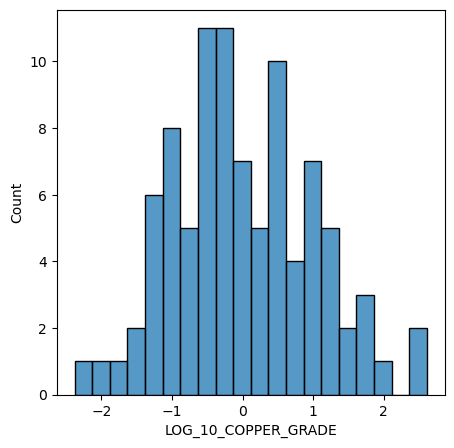

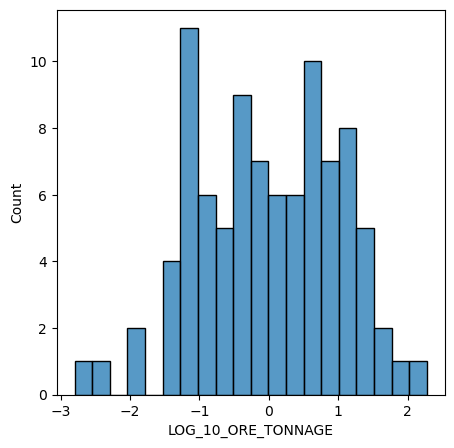

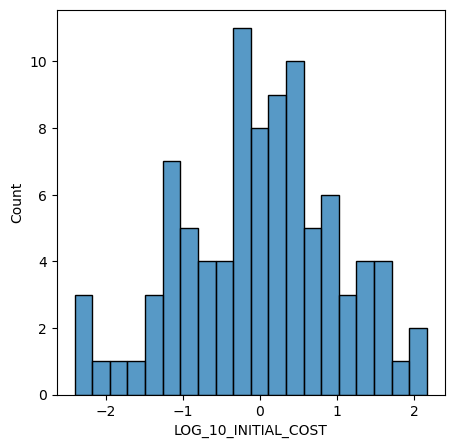

In [68]:
for col in X_train.columns:
    plt.figure(figsize=(5,5))
    sns.histplot(X_train_knn[col], bins=20)
    plt.show()

<Axes: >

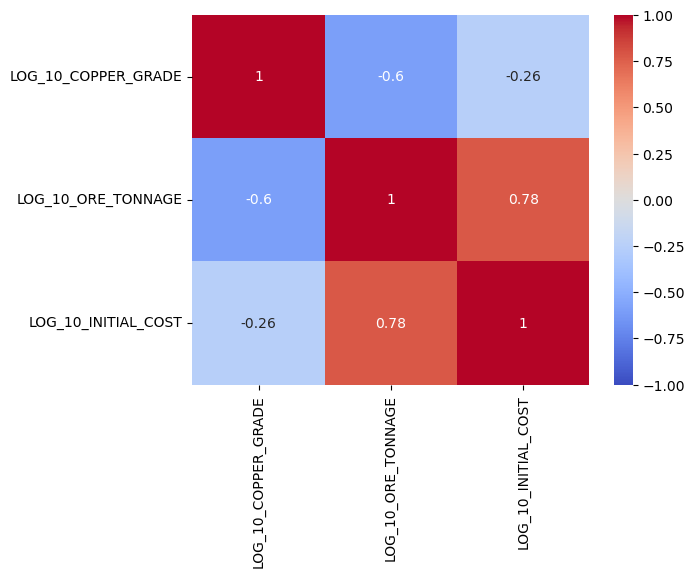

In [69]:
sns.heatmap(X_train_knn.corr(), annot=True, cmap='coolwarm', vmax=1, vmin=-1)

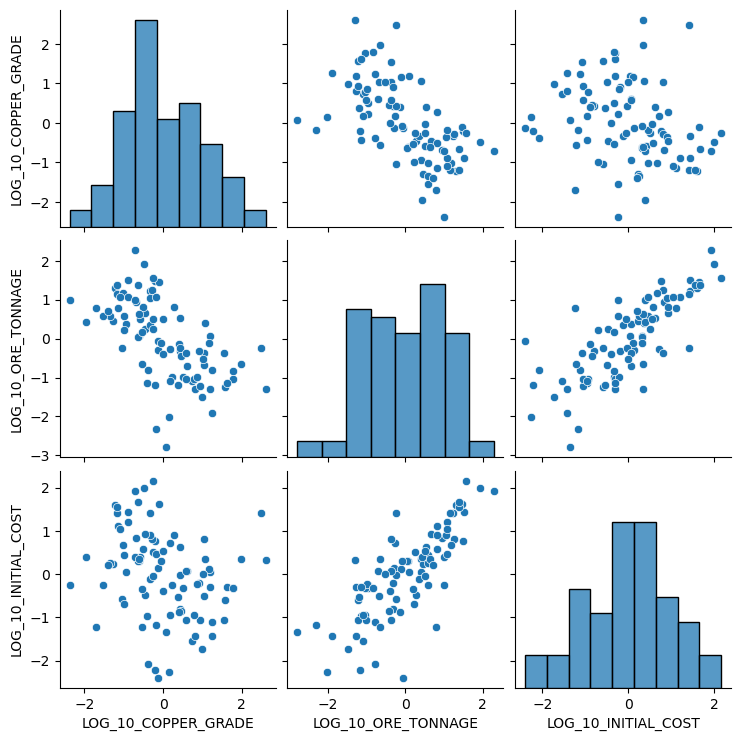

In [70]:
sns.pairplot(X_train_knn)

In [89]:
col_x = 'LOG_10_COPPER_GRADE'
col_y = 'LOG_10_ORE_TONNAGE'
col_z = 'LOG_10_INITIAL_COST'
df = X_train_knn

fig = go.Figure(data=[go.Surface(x=df[col_x].values, 
                                 y=df[col_y].values, 
                                 z=df[col_z].values)])

fig = go.Figure(data=[go.Scatter3d(
    x=df[col_x].values, 
    y=df[col_y].values, 
    z=df[col_z].values,
    mode='markers',
    marker=dict(
        size=5,
        color=(y_train > 15).astype(int),
        colorscale='viridis',
        opacity=0.8
    )
)])

# Customize the plot
fig.update_layout(
    title='3D Surface Plot',
    scene=dict(
        xaxis_title=col_x,
        yaxis_title=col_y,
        zaxis_title=col_z
    ),
    width=800,
    height=800
)

# Show the plot
fig.show()
fig.write_html('prob_simple_categorical.html')

In [91]:
col_x = 'LOG_10_COPPER_GRADE'
col_y = 'LOG_10_ORE_TONNAGE'
col_z = 'LOG_10_INITIAL_COST'
df = X_train_knn

fig = go.Figure(data=[go.Surface(x=df[col_x].values, 
                                 y=df[col_y].values, 
                                 z=df[col_z].values)])

fig = go.Figure(data=[go.Scatter3d(
    x=df[col_x].values, 
    y=df[col_y].values, 
    z=df[col_z].values,
    mode='markers',
    marker=dict(
        size=5,
        color=y_train,
        colorscale='reds',
        opacity=0.8
    )
)])

# Customize the plot
fig.update_layout(
    title='3D Surface Plot',
    scene=dict(
        xaxis_title=col_x,
        yaxis_title=col_y,
        zaxis_title=col_z
    ),
    width=800,
    height=800
)

# Show the plot
fig.show()
fig.write_html('prob_simple_numerical.html')

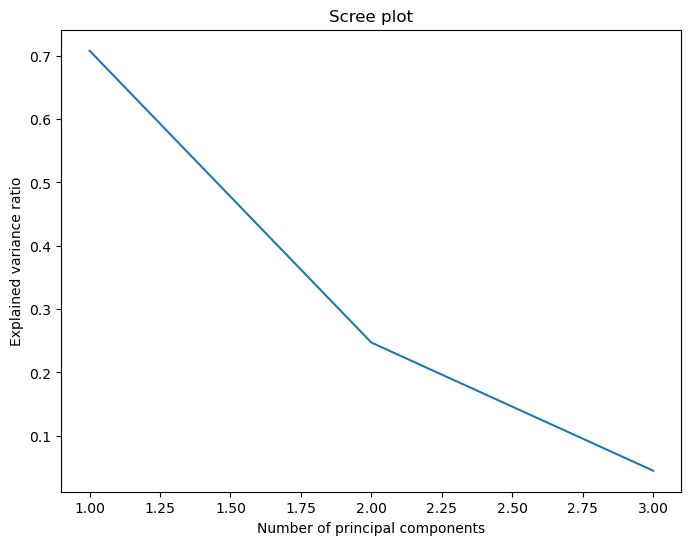

In [73]:
# Perform PCA
pca = PCA()
pca.fit(X_train_knn)

# Get the principal components
principal_components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance ratio')
plt.title('Scree plot')
plt.show()

In [75]:
X_train_pca = pca.transform(X_train_knn)[:,:2]
X_train_pca = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'], index=X_train_knn.index)

<Axes: xlabel='PC1', ylabel='PC2'>

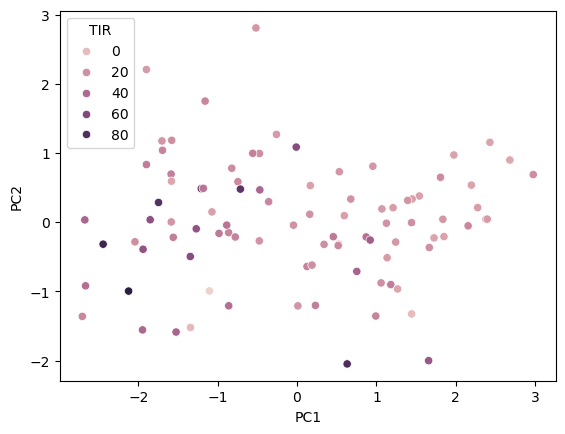

In [78]:
sns.scatterplot(x='PC1', y='PC2', data=X_train_pca, hue=y_train)

<Axes: xlabel='PC1', ylabel='Count'>

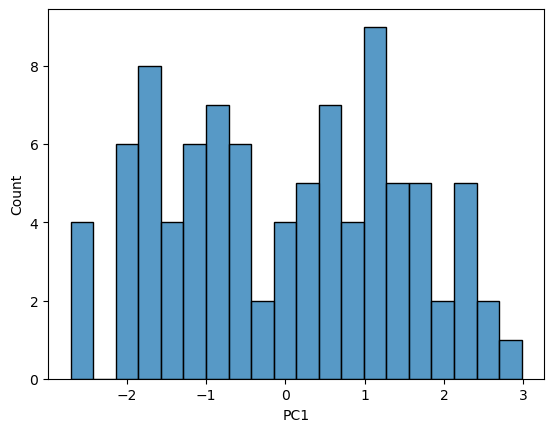

In [80]:
sns.histplot(X_train_pca['PC1'], bins=20)

<Axes: xlabel='PC2', ylabel='Count'>

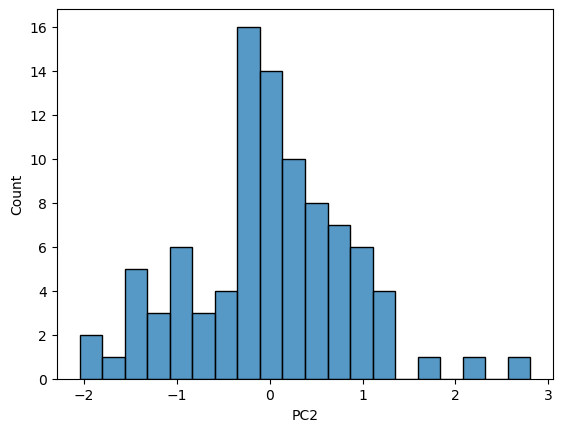

In [81]:
sns.histplot(X_train_pca['PC2'], bins=20)

<Axes: xlabel='PC1', ylabel='PC2'>

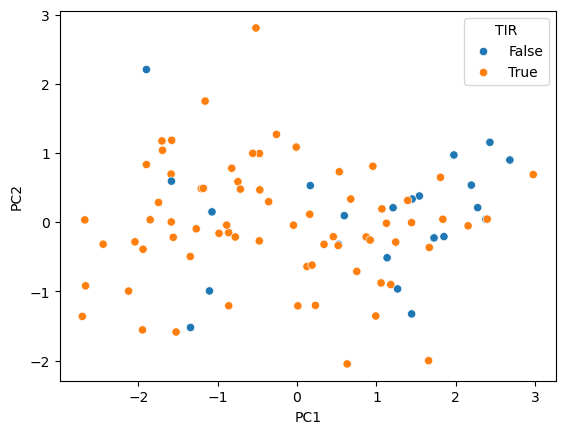

In [79]:
sns.scatterplot(x='PC1', y='PC2', data=X_train_pca, hue=y_train>15)

<Axes: xlabel='PC1', ylabel='TIR'>

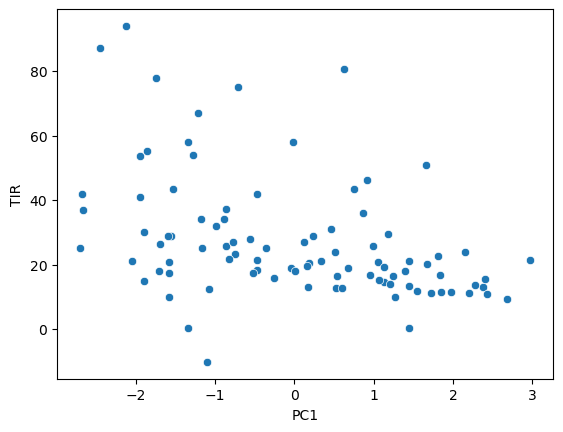

In [83]:
sns.scatterplot(x='PC1', y=y_train, data=X_train_pca)

<Axes: xlabel='PC2', ylabel='TIR'>

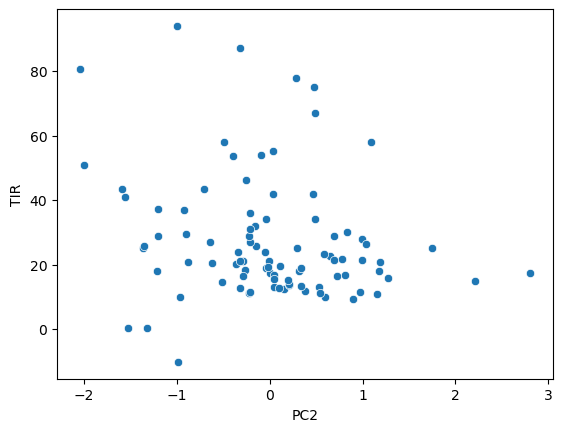

In [84]:
sns.scatterplot(x='PC2', y=y_train, data=X_train_pca)

In [127]:
col_x = 'PC1'
col_y = 'PC2'
df = X_train_pca

fig = go.Figure(data=[go.Surface(x=df[col_x].values, 
                                 y=df[col_y].values, 
                                 z=y_train)])

fig = go.Figure(data=[go.Scatter3d(
    x=df[col_x].values, 
    y=df[col_y].values, 
    z=y_train,
    mode='markers',
    marker=dict(
        size=5,
        color=(y_train > 15).astype(int),
        colorscale='viridis',
        opacity=0.8
    )
)])

# Customize the plot
fig.update_layout(
    title='3D Surface Plot',
    scene=dict(
        xaxis_title=col_x,
        yaxis_title=col_y,
        zaxis_title='TIR'
    ),
    width=800,
    height=600
)

# Show the plot
fig.show()

In [108]:
#for perp in range(5, 70, 5):
#    tsne = TSNE(n_components=2, learning_rate='auto',
#                    init='random', perplexity=perp, random_state=42)

#    X_train_tsne = tsne.fit_transform(X_train_knn)
#    X_train_tsne = pd.DataFrame(X_train_tsne, columns=['TSNE1', 'TSNE2'], index=X_train_knn.index)
#    sns.scatterplot(x='TSNE1', y='TSNE2', data=X_train_tsne, hue=y_train>15)
#    plt.title(f'Perplexity: {perp}')
#    plt.show()

In [120]:
tsne = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=45, random_state=42)

X_train_tsne = tsne.fit_transform(X_train_knn)
X_train_tsne = pd.DataFrame(X_train_tsne, columns=['TSNE1', 'TSNE2'], index=X_train_knn.index)

<Axes: xlabel='TSNE1', ylabel='Count'>

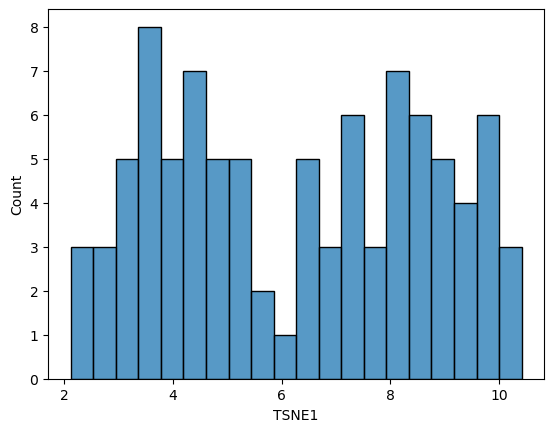

In [123]:
sns.histplot(X_train_tsne['TSNE1'], bins=20)

<Axes: xlabel='TSNE2', ylabel='Count'>

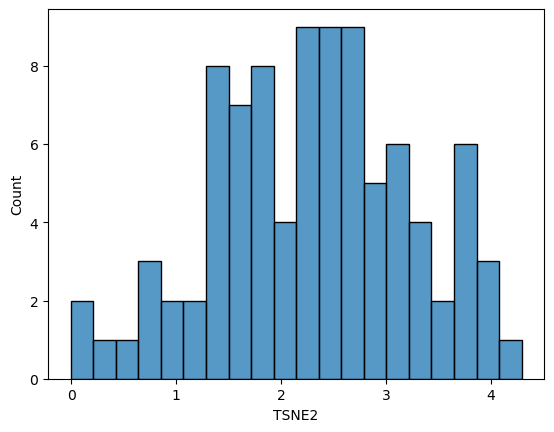

In [124]:
sns.histplot(X_train_tsne['TSNE2'], bins=20)

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

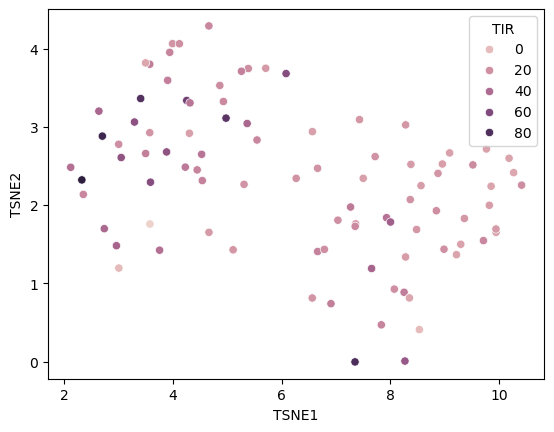

In [121]:
sns.scatterplot(x='TSNE1', y='TSNE2', data=X_train_tsne, hue=y_train)

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

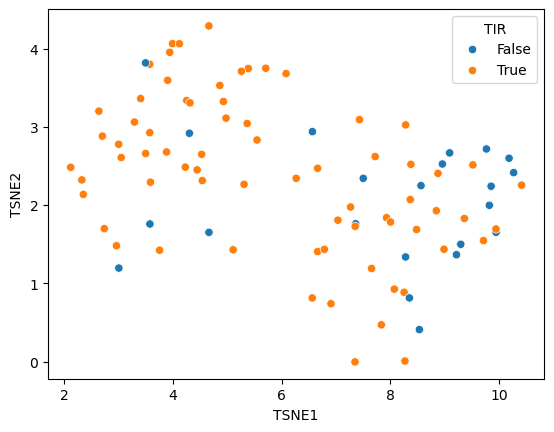

In [122]:
sns.scatterplot(x='TSNE1', y='TSNE2', data=X_train_tsne, hue=y_train>15)

In [126]:
col_x = 'TSNE1'
col_y = 'TSNE2'
df = X_train_tsne

fig = go.Figure(data=[go.Surface(x=df[col_x].values, 
                                 y=df[col_y].values, 
                                 z=y_train)])

fig = go.Figure(data=[go.Scatter3d(
    x=df[col_x].values, 
    y=df[col_y].values, 
    z=y_train,
    mode='markers',
    marker=dict(
        size=5,
        color=(y_train > 15).astype(int),
        colorscale='viridis',
        opacity=0.8
    )
)])

# Customize the plot
fig.update_layout(
    title='3D Surface Plot',
    scene=dict(
        xaxis_title=col_x,
        yaxis_title=col_y,
        zaxis_title='TIR'
    ),
    width=800,
    height=800
)

# Show the plot
fig.show()